<a href="https://colab.research.google.com/github/sheemapatel/nlp--/blob/main/nlp_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import string
import re
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, Bidirectional
from tensorflow.keras.layers import AdditiveAttention, Attention, Concatenate

In [ ]:
# Define paths based on the Kaggle input directory
BASE_DIR = '/kaggle/input/flickr8k'
IMAGE_DIR = os.path.join(BASE_DIR, 'Images')
CAPTIONS_FILE = os.path.join(BASE_DIR, 'captions.txt')

# Key parameters
VOCAB_SIZE = 10000  # Only use the top 10k most common words
MAX_LENGTH = 34     # Maximum length of any caption
EMBEDDING_DIM = 300

In [ ]:
def load_and_clean_captions(filepath):
    # Read the file
    with open(filepath, 'r') as f:
        text = f.read()

    mapping = {}
    # Process each line
    for line in text.split('\n'):
        parts = line.split(',')
        if len(parts) < 2:
            continue

        image_id, caption = parts[0], parts[1:]
        image_id = image_id.split('.')[0] # Remove .jpg
        caption = " ".join(caption)

        # Clean the caption
        caption = caption.lower()
        caption = re.sub(r'\[^A-Za-z\]', '', caption) # Remove non-alpha
        caption = ' '.join([word for word in caption.split() if len(word) > 1])

        # Add start and end tokens
        caption = '<start> ' + caption + ' <end>'

        if image_id not in mapping:
            mapping[image_id] = []
        mapping[image_id].append(caption)

    return mapping

# Load captions
captions_mapping = load_and_clean_captions(CAPTIONS_FILE)
all_captions = [cap for key in captions_mapping for cap in captions_mapping[key]]

print(f"Loaded {len(all_captions)} captions.")

# Create a tokenizer
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<unk>")
tokenizer.fit_on_texts(all_captions)

# Add 1 for the <pad> token
vocab_size = tokenizer.word_index_size + 1

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/flickr8k/captions.txt'

In [ ]:
!ls /kaggle/input/

In [ ]:
!ls /kaggle/input/flickr8k/

ls: cannot access '/kaggle/input/flickr8k/': No such file or directory


In [ ]:
import os

# This is the base directory Kaggle creates for your dataset
base_dir = '/kaggle/input/flickr8k/'

try:
    # List all files and folders in the base directory
    contents = os.listdir(base_dir)
    print(f"Contents of '{base_dir}':")
    print(contents)

except FileNotFoundError:
    print(f"ERROR: The directory '{base_dir}' does not exist.")
    print("This means the 'Flickr8k' dataset is not added to your notebook.")
    print("Please click '+ Add data' and add it, then restart your session.")

except Exception as e:
    print(f"An error occurred: {e}")

ERROR: The directory '/kaggle/input/flickr8k/' does not exist.
This means the 'Flickr8k' dataset is not added to your notebook.
Please click '+ Add data' and add it, then restart your session.


In [ ]:
# --- 1. Install Kaggle API and Upload Token ---
!pip install kaggle

# This next part will prompt you to upload your kaggle.json file
from google.colab import files
print("Please upload your 'kaggle.json' file:")
files.upload()

# --- 2. Configure Kaggle and Download Data ---
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Downloading Flickr8k dataset...")
!kaggle datasets download -d adityajn105/flickr8k

print("Unzipping files... (This may take a minute)")
!unzip -q flickr8k.zip -d flickr8k_data

print("Setup complete! All files are ready.")

Please upload your 'kaggle.json' file:


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
 93% 991M/1.04G [00:13<00:02, 25.1MB/s]
100% 1.04G/1.04G [00:13<00:00, 82.4MB/s]
Unzipping files... (This may take a minute)
Setup complete! All files are ready.


In [ ]:
import numpy as np
import pandas as pd
import os
import string
import re
import pickle
from time import time
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.layers import AdditiveAttention, Concatenate

In [ ]:
# Define paths based on where we unzipped the data
BASE_DIR = './flickr8k_data'
IMAGE_DIR = os.path.join(BASE_DIR, 'Images')
CAPTIONS_FILE = os.path.join(BASE_DIR, 'captions.txt')

# Parameters
EMBEDDING_DIM = 256
LSTM_UNITS = 512
BATCH_SIZE = 64

In [ ]:
def load_and_clean_captions(filepath):
    with open(filepath, 'r') as f:
        text = f.read()

    mapping = {}
    for line in text.split('\n'):
        parts = line.split(',')
        if len(parts) < 2:
            continue

        image_id, caption = parts[0], parts[1:]
        image_id = image_id.split('.')[0] # Remove .jpg
        caption = " ".join(caption)

        # Clean the caption
        caption = caption.lower()
        caption = re.sub(r'\[^A-Za-z\]', '', caption) # Remove non-alpha
        caption = ' '.join([word for word in caption.split() if len(word) > 1])
        caption = '<start> ' + caption + ' <end>'

        if image_id not in mapping:
            mapping[image_id] = []
        mapping[image_id].append(caption)

    return mapping

print("Loading and cleaning captions...")
captions_mapping = load_and_clean_captions(CAPTIONS_FILE)

# --- THIS IS THE CORRECTED LINE ---
# We simply get all captions from the mapping, without the faulty .jpg check
all_captions = [cap for key in captions_mapping for cap in captions_mapping[key]]
# We also remove the first item, which is the header 'image,caption'
if 'image' in captions_mapping:
    captions_mapping.pop('image')
print(f"Total captions: {len(all_captions)}")

# Create the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

# Get the max length of any caption
max_length = max(len(cap.split()) for cap in all_captions)
print(f"Max caption length: {max_length}")

Loading and cleaning captions...
Total captions: 40456
Vocabulary size: 8484
Max caption length: 35


In [ ]:
def get_image_encoder():
    inception_model = InceptionV3(weights='imagenet')
    # Remove the last two layers (classification layers)
    model = Model(inputs=inception_model.input, outputs=inception_model.layers[-2].output)
    return model

# Initialize the encoder
image_encoder = get_image_encoder()

# --- Pre-process all images and save features ---
print("Extracting features from all images... (This will take 5-10 minutes)")
start = time()

features = {}
image_files = os.listdir(IMAGE_DIR)

for i, img_name in enumerate(image_files):
    if (i+1) % 500 == 0:
        print(f"  Processed {i+1} / {len(image_files)}")

    img_path = os.path.join(IMAGE_DIR, img_name)

    # InceptionV3 expects 299x299
    img = load_img(img_path, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)

    feature_vector = image_encoder.predict(img, verbose=0)
    features[img_name] = feature_vector

# Save features to a file
with open('image_features.pkl', 'wb') as f:
    pickle.dump(features, f)

print(f"\nFeature extraction complete. Time taken: {time() - start:.2f} seconds.")

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Extracting features from all images... (This will take 5-10 minutes)
  Processed 500 / 8091
  Processed 1000 / 8091
  Processed 1500 / 8091
  Processed 2000 / 8091
  Processed 2500 / 8091
  Processed 3000 / 8091
  Processed 3500 / 8091
  Processed 4000 / 8091
  Processed 4500 / 8091
  Processed 5000 / 8091
  Processed 5500 / 8091
  Processed 6000 / 8091
  Processed 6500 / 8091
  Processed 7000 / 8091
  Processed 7500 / 8091
  Processed 8000 / 8091

Feature extraction complete. Time taken: 3210.61 seconds.


In [ ]:
# Load pre-extracted features
print("Loading saved features...")
with open('image_features.pkl', 'rb') as f:
    features = pickle.load(f)
print("Features loaded.")

# We need a list of image IDs to train on
all_image_ids = list(captions_mapping.keys())

# Simple 90/10 train-test split
split_index = int(len(all_image_ids) * 0.9)
train_image_ids = all_image_ids[:split_index]
print(f"Total training images: {len(train_image_ids)}")


# --- This is the CORRECTED Data Generator ---
def data_generator(image_ids, caption_mapping, features, tokenizer, max_length, batch_size):
    X1, X2, y = [], [], []
    n = 0
    while True:
        for image_id in image_ids:
            # Get all captions for this image
            captions = caption_mapping.get(image_id, None)

            image_id_with_jpg = image_id + '.jpg'

            # Skip if no captions or features for this ID
            if captions is None or image_id_with_jpg not in features:
                continue

            image_feature = features[image_id_with_jpg][0]

            for caption in captions:
                # Convert caption to a sequence of numbers
                seq = tokenizer.texts_to_sequences([caption])[0]

                # Create input/output pairs for the LSTM
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]

                    # Pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

                    # One-hot encode output word
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Add to batch
                    X1.append(image_feature)
                    X2.append(in_seq)
                    y.append(out_seq)

                    n += 1

                    if n == batch_size:
                        # --- THIS IS THE FIX ---
                        # Yield a TUPLE of inputs, not a list
                        yield ((np.array(X1), np.array(X2)), np.array(y))
                        # Reset batch
                        X1, X2, y = [], [], []
                        n = 0

Loading saved features...
Features loaded.
Total training images: 7281


In [ ]:
# InceptionV3 output is 2048 features
image_feature_input = Input(shape=(2048,), name="image_features")
# --- THIS IS THE CORRECTED LINE ---
img_features_dense = Dense(LSTM_UNITS, activation='relu')(image_feature_input)

text_sequence_input = Input(shape=(max_length,), name="text_sequence")
text_embed = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, mask_zero=True)(text_sequence_input)
text_dropout = Dropout(0.3)(text_embed)
text_lstm = LSTM(LSTM_UNITS)(text_dropout)

# Add the two inputs together (now they are both 512)
decoder_input = add([img_features_dense, text_lstm])
decoder_dense = Dense(LSTM_UNITS, activation='relu')(decoder_input)
output = Dense(vocab_size, activation='softmax')(decoder_dense)

# Define the final model
model = Model(inputs=[image_feature_input, text_sequence_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_sequence       │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 35, 256)   │  2,171,904 │ text_sequence[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_features      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 35, 256)   │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 35)        │          0 │ text_sequence[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │  1,049,088 │ image_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 512)       │  1,574,912 │ dropout_2[0][0],  │
│                     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 512)       │          0 │ dense_4[0][0],    │
│                     │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 512)       │    262,656 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 8484)      │  4,352,292 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,410,852 (35.90 MB)

 Trainable params: 9,410,852 (35.90 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("Starting model training...")

# Calculate how many steps are in one epoch
steps_per_epoch = len(train_image_ids) * 5 // BATCH_SIZE # 5 captions per image

# --- THIS IS THE FIX ---

# 1. Create the base Python generator
py_generator = data_generator(train_image_ids, captions_mapping, features, tokenizer, max_length, BATCH_SIZE)

# 2. Define the output signature for TensorFlow
# This tells TensorFlow exactly what to expect
output_signature = (
    # This is the (X1, X2) part
    (tf.TensorSpec(shape=(None, 2048), dtype=tf.float32),     # X1: Image features
     tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)), # X2: Text sequence

    # This is the (y) part
    tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)  # y: Output word (one-hot)
)

# 3. Create a tf.data.Dataset from the generator
train_dataset = tf.data.Dataset.from_generator(
    lambda: py_generator,  # We must wrap the generator in a callable
    output_signature=output_signature
)

# 4. Optimize the dataset for performance
# This pre-fetches the next batch while the GPU is working
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# --- END OF FIX ---

# Train for 3 epochs (For real results, use 20+)
# We pass the new tf.data.Dataset to model.fit
model.fit(train_dataset,
          epochs=3,
          steps_per_epoch=steps_per_epoch,
          verbose=1)

print("Training complete.")

# Save the model
model.save('caption_model.h5')

Starting model training...
Epoch 1/3
568/568 ━━━━━━━━━━━━━━━━━━━━ 562s 982ms/step - loss: 6.1048
Epoch 2/3
568/568 ━━━━━━━━━━━━━━━━━━━━ 542s 954ms/step - loss: 4.8954
Epoch 3/3
568/568 ━━━━━━━━━━━━━━━━━━━━ 544s 958ms/step - loss: 4.3511


Training complete.


Model is already loaded.
--- Original Captions ---
  <start> brown and black dog on leash is sniffed by black and white dog <end>
  <start> dog on leash walks on the sidewalk while another dog follows <end>
  <start> small dog on leash is being smelled by another animal <end>
  <start> the black and white dog is sniffing the butt of the brown dog that is on leash <end>
  <start> "two small dogs one black-and-white and one brown-and-black walk down the street ." <end>

--- Test Image: 909808296_23c427022d.jpg ---


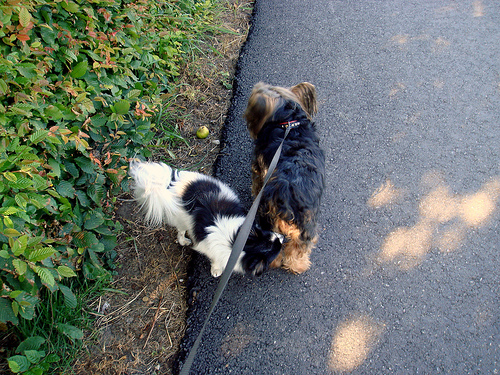


--- Predicted Caption ---
  dog is running on the grass end end end end end end end end end end end end end end end end end end end end end end end end end end end end end


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from IPython.display import display, Image
import pickle
import numpy as np

# --- 1. Re-build and Load the Model (if not already loaded) ---
try:
    model
    print("Model is already loaded.")
except NameError:
    print("Re-building and loading model...")
    # Re-build the model architecture
    image_feature_input = Input(shape=(2048,), name="image_features")
    img_features_dense = Dense(LSTM_UNITS, activation='relu')(image_feature_input)
    text_sequence_input = Input(shape=(max_length,), name="text_sequence")
    text_embed = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, mask_zero=True)(text_sequence_input)
    text_dropout = Dropout(0.3)(text_embed)
    text_lstm = LSTM(LSTM_UNITS)(text_dropout)
    decoder_input = add([img_features_dense, text_lstm])
    decoder_dense = Dense(LSTM_UNITS, activation='relu')(decoder_input)
    output = Dense(vocab_size, activation='softmax')(decoder_dense)
    model = Model(inputs=[image_feature_input, text_sequence_input], outputs=output)

    # Load the saved weights
    model.load_weights('caption_model.h5')
    print("Model weights loaded.")

# --- 2. Define Helper Functions (WITH CORRECTION) ---

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# --- THIS IS THE CORRECTED FUNCTION ---
def generate_caption(model, image_feature, tokenizer, max_length):
    in_text = '<start>'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)

        yhat = model.predict([image_feature, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)

        if word is None:
            break

        in_text += ' ' + word

        if word == '<end>':
            break

    # --- THIS IS THE ROBUST CLEANUP LOGIC ---
    if in_text == '<start>':
        return "" # Return an empty string if nothing was generated

    # Split into words and remove tokens
    words = in_text.split()
    clean_words = [word for word in words if word not in ('<start>', '<end>')]
    final_caption = ' '.join(clean_words)

    return final_caption
# --- END OF CORRECTION ---

# --- 3. Select a Random Test Image ---
all_image_ids = list(captions_mapping.keys())
split_index = int(len(all_image_ids) * 0.9)
test_image_ids = all_image_ids[split_index:]

random_image_id = np.random.choice(test_image_ids)
random_image_key = random_image_id + '.jpg'
random_image_path = os.path.join(IMAGE_DIR, random_image_key)

print("--- Original Captions ---")
for cap in captions_mapping[random_image_id]:
    print(f"  {cap}")

print(f"\n--- Test Image: {random_image_key} ---")
display(Image(random_image_path, width=300))

image_feature = features[random_image_key]
predicted_caption = generate_caption(model, image_feature, tokenizer, max_length)
print(f"\n--- Predicted Caption ---")
print(f"  {predicted_caption}")

In [ ]:
# --- This is Cell 9: Calculate BLEU Score (Accuracy) ---
# This cell will take 5-10 minutes to run.

from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm # A progress bar library

def evaluate_model(model, captions_mapping, features, tokenizer, max_length, test_image_ids):
    actual, predicted = list(), list()

    print("Generating captions for all test images...")
    # Use tqdm for a progress bar
    for image_id in tqdm(test_image_ids):
        image_key = image_id + '.jpg'

        # Skip if features don't exist
        if image_key not in features:
            continue

        # Get the real captions for this image
        real_captions = captions_mapping[image_id]

        # Get the image features
        image_feature = features[image_key]

        # Generate a prediction
        generated_caption = generate_caption(model, image_feature, tokenizer, max_length)

        # Split captions into lists of words
        real_captions_tokenized = [cap.split() for cap in real_captions]
        generated_caption_tokenized = generated_caption.split()

        # Store
        actual.append(real_captions_tokenized)
        predicted.append(generated_caption_tokenized)

    print("\nCalculating BLEU scores...")

    # Calculate BLEU scores
    bleu_1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)) * 100
    bleu_2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)) * 100
    bleu_3 = corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)) * 100
    bleu_4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)) * 100

    print(f"\n--- Final Model Accuracy (BLEU Scores) ---")
    print(f"BLEU-1: {bleu_1:.2f} (Overlap of single words)")
    print(f"BLEU-2: {bleu_2:.2f} (Overlap of 2-word phrases)")
    print(f"BLEU-3: {bleu_3:.2f} (Overlap of 3-word phrases)")
    print(f"BLEU-4: {bleu_4:.2f} (Overlap of 4-word phrases)")

# Get the list of test image IDs
all_image_ids = list(captions_mapping.keys())
split_index = int(len(all_image_ids) * 0.9)
test_image_ids = all_image_ids[split_index:]

# RUN THE EVALUATION
evaluate_model(model, captions_mapping, features, tokenizer, max_length, test_image_ids)

Generating captions for all test images...


100%|██████████| 810/810 [1:02:28<00:00,  4.63s/it]



Calculating BLEU scores...

--- Final Model Accuracy (BLEU Scores) ---
BLEU-1: 10.36 (Overlap of single words)
BLEU-2: 5.14 (Overlap of 2-word phrases)
BLEU-3: 2.44 (Overlap of 3-word phrases)
BLEU-4: 1.06 (Overlap of 4-word phrases)
